In [1]:
import numpy as np
from threeflavorALLvalues import allSigmas
from scipy.integrate import odeint
from solveTmu import blackness
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import brentq, fsolve

from joblib import Parallel, delayed

import matplotlib.pyplot as plt


In [2]:
"Matching Fang paper"
v4=4.2
v3= -22.6/(6*np.sqrt(2))

def chiral(u,y,params):
    chi,chip=y
    v3,v4,lambda1,mu_g,a0,zh,q=params
    
    Q=q*zh**3
    
    
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
    phip = 2*u*(zh*mu_g)**2+a0*(4*u**6*(zh*mu_g)**7/(1+(u*zh*mu_g)**4)**2-3*u**2*(zh*mu_g)**3/(1+(u*zh*mu_g)**4))

    f= 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp= -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    "EOM for chiral field"
    derivs=[chip,
            (3/u-fp/f+phip)*chip - (3*chi+lambda1*phi*chi-3*v3*chi**2-4*v4*chi**3)/(u**2*f)]
            #((3+u**4)/(u-u**5) +phip)*chip - (-3*chi+4*v4*chi**3)/(u**2-u**6) ]
            
    return derivs

def chiral_solve_IR(d0,lambda1,T,mu,ui,uf):
    numpoints=10000
    u=np.linspace(ui,uf,numpoints)
    u_backward=np.linspace(uf,ui,numpoints)


    zeta=np.sqrt(3)/(2*np.pi)

    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4


    zh,q = blackness(T,mu)
    Q=q*zh**3
    
    #defining constants for Taylor expansion at horizon u=1

    d1 = (3 * d0 - 3 * d0**2 * lambda3 - 4 * d0**3 * lambda4 + d0 * zh**2 * lambda1 * mu_g**2) / (2 * (-2 + Q**2))

    d2 = (1 / (16 * (-2 + Q**2)**2)) * (6 * d1 * (-6 + Q**2 + Q**4) +
    4 * d0**3 * (14 - 13 * Q**2) * lambda4 + d0**2 * ((42 - 39 * Q**2) * lambda3 - 24 * d1 * (-2 + Q**2) * lambda4) -
    2 * d1 * (-2 + Q**2) * zh**2 * (-8 + 4 * Q**2 - lambda1) * mu_g**2 +
    3 * d0 * (-14 + 13 * Q**2 + 8 * d1 * lambda3 - 4 * d1 * Q**2 * lambda3 + (-2 + 3 * Q**2) * zh**2 * lambda1 * mu_g**2))
    

    "IR boundary condition"
    chi0 = d0+d1*(1-uf)+d2*(1-uf)**2
    chip0 = -d1-2*d2*(1-uf)
    y0=[chi0,chip0]




    params=v3,v4,lambda1,mu_g,a0,zh,q
    
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [uf, ui], y0, t_eval=u_backward, args=(params,))

    #sol=odeint(chiral,y0,u,args=(params,))
    #plot
    chi=sol.y[0][::-1]
    chip=sol.y[1][::-1]
 
    x=zeta*zh*ui
    #first-order approximation
    if v3==0:
        mq1=chi[0]/(zeta*zh*ui)
    else:
        #second-order approximation
       mq1=(x-x*np.sqrt(1-12*v3*chi[0]))/(6*x**2*v3)


    return mq1,chi,chip,u

def sigma_finder(u_intermediate,chi,u,mq,T,mu,zeta,lambda3):
    zh,q = blackness(T,mu)

    "find sigma"
    chi_interp=interp1d(u,chi)
    sigma=(chi_interp(u_intermediate)-mq*zeta*zh*u_intermediate+3*mq**2*zeta**2*lambda3*(zh*u_intermediate)**2)/(u_intermediate*zh)**3*zeta
    return sigma


def chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(chiral_solve_IR)(d0, lambda1, T, mu, ui, uf) for d0 in d0_array
    )
    # Unpack the results
    mq_array, chi_array, chip_array, u_array = zip(*results)
    
    return np.array(mq_array), np.array(chi_array), np.array(chip_array)

In [3]:
#run this to get the initial range of mq vs d0
#mq target should be 50 MeV or some large number
def initial_d0_mq(T,mu,mq_target,lambda1,ui,uf,d0_array):
    
#     d0_array=np.linspace(d0_lower,d0_upper,100)
    mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)[0]

    max_d0=d0_upper
    # find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
    indices=np.where(np.abs(mq_array)>150)
    # we don't need to go higher than the lowest d0 value that gives garbage results
    # if indices is not an empty array
    if len(indices[0])>0:
        max_d0=d0_array[indices[0]]
    if len(indices[0])>1:
        max_d0=max_d0[0]

    d0_array=np.delete(d0_array,indices)
    mq_array=np.delete(mq_array,indices)
#     mq1_array=np.delete(mq1_array,indices)
    
    iterations=0
    step_size=d0_array[1]-d0_array[0]
    while mq_array[-1]<mq_target and iterations<20:
    #while max(mq_array)<mq_target and iterations<12:

        #create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
        step_size=step_size/100
        d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/20,max_d0),step_size)

        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),((d0_array[1]-d0_array[0])/100))
        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)
        d0_array=np.concatenate((d0_array,d0_new))
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)[0]
        #add the new mq_array to the old mq_array
        mq_array=np.concatenate((mq_array,mq_new))
#         mq1_array=np.concatenate((mq1_array,mq1_new))

        
        indices=np.where(np.abs(mq_array)>150)
        # we don't need to go higher than the lowest d0 value that gives garbage results
        # if indices is not an empty array
        if len(indices[0])>0:
            max_d0=d0_array[indices[0]]
        if len(indices[0])>1:
            max_d0=max_d0[0]    
        d0_array=np.delete(d0_array,indices)
        mq_array=np.delete(mq_array,indices)
#         mq1_array=np.delete(mq1_array,indices)

        # print(max_d0)
        old_max_d0=max_d0
        iterations=iterations+1
    # print('iterations',iterations)
    if mq_array[-1]-mq_array[-2]>5:
        #create an array of 10 new d0 values evenly spaced between the last two d0 values, that doesn't include either of the last two d0 values
        d0_new=np.linspace(d0_array[-2],d0_array[-1],10)[1:-1]
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)[0]
        #add the new mq_array to the old mq_array between the last two mq values, same for d0
        mq_array=np.concatenate((mq_array[:-1],mq_new,mq_array[-1:]))
        d0_array=np.concatenate((d0_array[:-1],d0_new,d0_array[-1:]))
    return d0_array,mq_array

# finding a range of d0 values that will cover quark masses in a range from 0 to approximately mq_large
T=1
mu=0
mq_large=15
lambda1=5.7
ui=1e-4
uf=1-ui
numpoints=100
d0_lower=70
d0_upper=88
d0_array=np.linspace(d0_lower,d0_upper,numpoints)
d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

d0_old=d0_array
d0_min=d0_array[np.abs(mq_array)>1e-3][0]
mq_array=mq_array[d0_array>d0_min]
d0_array=d0_array[d0_array>d0_min]
# it seems that the first two points are identical, so remove one
d0_array=d0_array[1:]
mq_array=mq_array[1:]
"This works, but makes WAY too many points"
# smallest_diff=np.min(np.gradient(d0_array))

# d0_array=np.arange(d0_array[0],d0_array[-1]+smallest_diff,smallest_diff)

# d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

# solving from IR again to retain the function chi and its derivative chip for each value of d0
_,chis,chips=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)

#picking the value of u_int. There are 1000 points in u, so i ~ 1000*u_int
i=10
u=np.linspace(ui,uf,len(chips[0]))
u_int=u[i]
chi0=chis[:,i]
chip0=chips[:,i]

#solving for mq and sigma
lambda3=v3
zeta=np.sqrt(3)/(2*np.pi)
zh,q=blackness(T,mu)
# if lambda3 is nonzero, calculate mq and sigma using the improved formula
# if lambda3 is zero, calculate mq and sigma using the round formula
if lambda3==0:
    sigma_improved=zeta*(chip0*u_int-chi0)/(2*u_int**3*zh**3)
    mq_improved=mq_array#chi0/(zeta*zh*u_int)
else:
    mq_improved=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
    sigma_improved=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)



/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_50062/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


In [329]:
# The function that will run in parallel
def process_mq_target(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3):
    # Your additional function calls like chiral_solve_IR, blackness go here
    
    d0_list = d0_array.tolist()
    mq_list = mq_improved.tolist()
    sigma_list = sigma_improved.tolist()
    
    indices = np.where(np.diff(np.sign(mq_improved - mq_target)))[0]
    
    results = []
    for index in indices:
        mq_approx = np.array([mq_improved[index], mq_improved[index + 1]])
        d0_approx = np.array([d0_array[index], d0_array[index + 1]])
        
        d0_interp = interp1d(mq_approx, d0_approx)
        d0 = d0_interp(mq_target)
        mq,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
#         print(mq)
        #picking the value of u_int. There are 1000 points in u, so i ~ 1000*u_int
        i=10
        u=np.linspace(ui,uf,len(chip))
        u_int=u[i]
        chi0=chi[i]
        chip0=chip[i]

        #solving for mq and sigma
        lambda3=v3
        zeta=np.sqrt(3)/(2*np.pi)
        zh,q=blackness(T,mu)
        # if lambda3 is nonzero, calculate mq and sigma using the improved formula
        # if lambda3 is zero, calculate mq and sigma using the round formula
        if lambda3==0:
            sigma_new=zeta*(chip0*u_int-chi0)/(2*u_int**3*zh**3)
            mq_new=mq#chi0/(zeta*zh*u_int)
        else:
            mq_new=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
            sigma_new=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)
            sigma_approx = zeta/(3*u_int**3*zh**3*lambda3)*(2*chip0*u_int-3/2*chi0)
            # sigma_improved=sigma_approx
#         print("d0=",d0)
        
        d0_list.append(d0)
        mq_list.append(mq_new)
        sigma_list.append(sigma_new)
        
    return np.array(d0_list), np.array(mq_list), np.array(sigma_list)

# Main code
numMass = 100
mq_overlay = np.linspace(np.min(mq_improved), mq_large, numMass)

results = Parallel(n_jobs=-1)(delayed(process_mq_target)(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3) for mq_target in mq_overlay)

# Aggregate results
all_d0_arrays = [res[0] for res in results]
all_mq_improved = [res[1] for res in results]
all_sigma_improved = [res[2] for res in results]

# Concatenating all the arrays
all_d0_array = np.concatenate(all_d0_arrays)
all_mq_improved = np.concatenate(all_mq_improved)
all_sigma_improved = np.concatenate(all_sigma_improved)

# Sorting by d0_array
sort_indices = np.argsort(all_d0_array)
all_d0_array = all_d0_array[sort_indices]
all_mq_improved = all_mq_improved[sort_indices]
all_sigma_improved = all_sigma_improved[sort_indices]

# Removing duplicate d0 values
unique_indices = np.unique(all_d0_array, return_index=True)[1]
final_d0_array = all_d0_array[unique_indices]
mq_improved = all_mq_improved[unique_indices]
sigma_improved = all_sigma_improved[unique_indices]




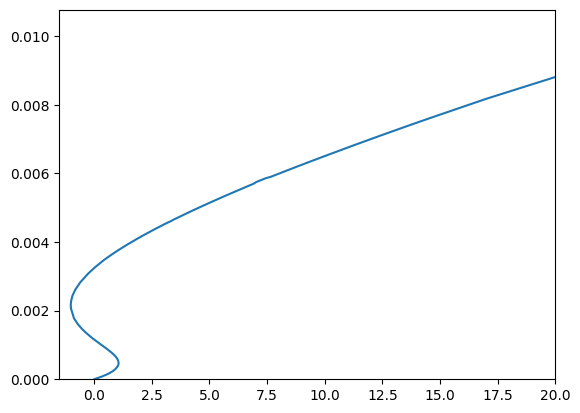

In [5]:
plt.plot(mq_improved,sigma_improved/1e9)
plt.xlim([min(mq_improved)-.5,20])
#make the ylimits from 0 to the value of sigma improved at approximately mq=20 (there may not be a value of sigma_improved at exactly mq=20)
plt.ylim([0,sigma_improved[np.where(mq_improved>20)[0][0]]/1e9])
plt.show()

In [388]:


# Assuming other required functions like chiral_solve_IR_parallel, chiral_solve_IR, and blackness are already defined

def new_function(lambda1, T, mu, mq_large, ui, uf, d0_lower, d0_upper, numpoints=100):
    # Initial d0 and mq arrays
    d0_array = np.linspace(d0_lower, d0_upper, numpoints)
    d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

    # Further processing to get mq_improved and sigma_improved
    _, chis, chips = chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)  # Assuming this function exists

    i = 10
    u = np.linspace(ui, uf, len(chips[0]))
    u_int = u[i]
    chi0 = chis[:, i]
    chip0 = chips[:, i]

    lambda3 = v3  
    zeta = np.sqrt(3) / (2 * np.pi)
    zh, q = blackness(T, mu)  
    
    if lambda3 == 0:
        sigma_improved = zeta * (chip0 * u_int - chi0) / (2 * u_int ** 3 * zh ** 3)
        mq_improved = mq_array
    else:
        mq_improved =(1 - np.sqrt(1 - 3 * lambda3 * (3 * chi0 - chip0 * u_int))) / (3 * lambda3 * zeta * u_int * zh)
        sigma_improved = zeta * (1 - 6 * chi0 * lambda3 + 3 * chip0 * u_int * lambda3 - np.sqrt(1 - 3 * lambda3 * (3 * chi0 - chip0 * u_int))) / (3 * u_int ** 3 * zh ** 3 * lambda3)
        sigma_approx = zeta/(3*u_int**3*zh**3*lambda3)*(2*chip0*u_int-3/2*chi0)
        # sigma_improved = sigma_approx

    # Run process_mq_target in parallel
    numMass = 100
    mq_overlay = np.linspace(np.min(mq_improved), mq_large, numMass)
    results = Parallel(n_jobs=-1)(delayed(process_mq_target)(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3) for mq_target in mq_overlay)

    # Aggregate and sort results
    all_d0_arrays = [res[0] for res in results]
    all_mq_improved = [res[1] for res in results]
    all_sigma_improved = [res[2] for res in results]
    
    all_d0_array = np.concatenate(all_d0_arrays)
    all_mq_improved = np.concatenate(all_mq_improved)
    all_sigma_improved = np.concatenate(all_sigma_improved)

    sort_indices = np.argsort(all_d0_array)
    all_d0_array = all_d0_array[sort_indices]
    all_mq_improved = all_mq_improved[sort_indices]
    all_sigma_improved = all_sigma_improved[sort_indices]

    unique_indices = np.unique(all_d0_array, return_index=True)[1]
    final_d0_array = all_d0_array[unique_indices]
    mq_improved = all_mq_improved[unique_indices]
    sigma_improved = all_sigma_improved[unique_indices]

    return mq_improved, sigma_improved, final_d0_array

# Note: The function uses variables like v3, chiral_solve_IR_parallel, blackness which should already be defined in your context.




/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_50062/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


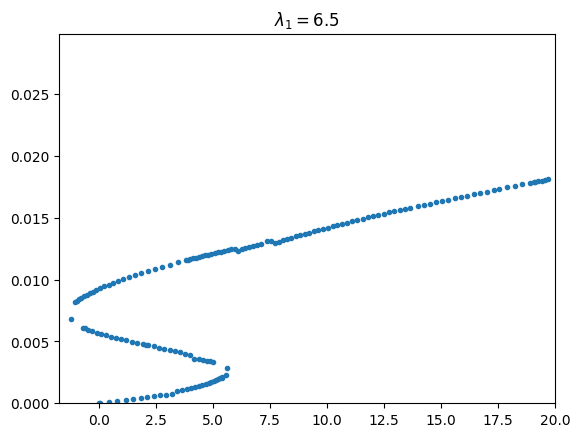

In [399]:
lambda1=6.5
T=120
mu=0
mq_large=20
ui=1e-2
uf=1-ui
d0_lower=0
d0_upper=10

mq_improved,sigma_improved, d0_array=new_function(lambda1,T,mu,mq_large,ui,uf,d0_lower,d0_upper,numpoints=100)

plt.plot(mq_improved,sigma_improved/1e9,'.')
plt.xlim([min(mq_improved)-.5,20])
#make the ylimits from 0 to the value of sigma improved at approximately mq=20 (there may not be a value of sigma_improved at exactly mq=20)
plt.ylim([0,sigma_improved[np.where(mq_improved>20)[0][0]]/1e9])
# plt.ylim([0,np.max(sigma_improved)/1e9])
plt.title('$\lambda_1=$'+str(lambda1))
plt.show()

In [371]:
mq_01=mq_improved
sigma_01=sigma_improved

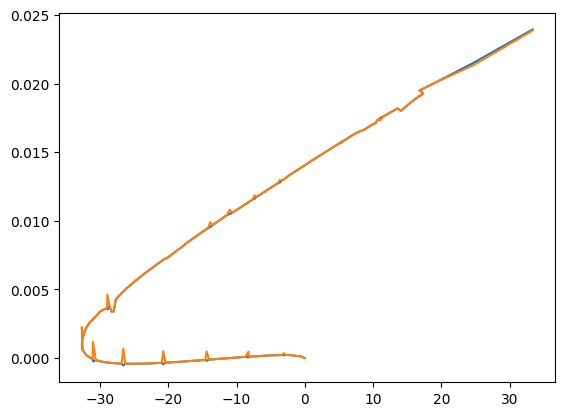

In [378]:
plt.plot(mq_01,sigma_01/1e9,label='ui=0.01')
plt.plot(mq_improved,sigma_improved/1e9)
# plt.plot(mq_1,sigma_1/1e9,label='ui=0.1')
plt.show()

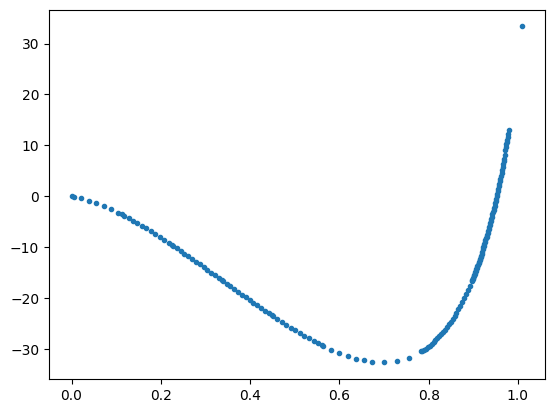

In [392]:
#plot mq vs d0
plt.plot(d0_array,mq_improved,'.')
plt.show()

In [292]:
mq_170=mq_improved
sigma_170=sigma_improved

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


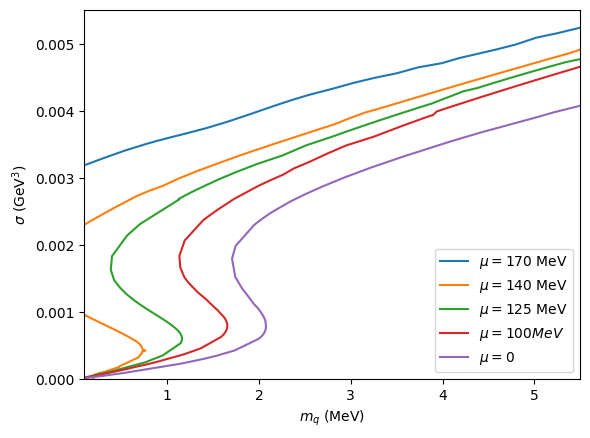

In [296]:
#plot sigma_improved vs mq_improved  and sigma_lowT vs mq_lowT on the same plot
plt.plot(mq_170,sigma_170/1e9,label='$\mu=170$ MeV')
plt.plot(mq_140,sigma_140/1e9,label='$\mu=140$ MeV')
plt.plot(mq_125,sigma_125/1e9,label='$\mu=125$ MeV')
plt.plot(mq_100,sigma_100/1e9,label='$\mu=100 MeV$')
# plt.xlim([min(mq_improved)-.5,10])
plt.xlim([0.1,5.5])
#make the ylimits from 0 to the value of sigma improved at approximately mq=20 (there may not be a value of sigma_improved at exactly mq=20)
plt.ylim([0,sigma_170[np.where(mq_170>6)[0][0]]/1e9])
# plt.title('$\lambda_1=$'+str(lambda1))
# plot mq vs sigma for low T with the label in latex T \rightarrow 0
plt.plot(mq_lowT,sigma_lowT/1e9,label='$\mu = 0$')
plt.xlabel('$m_q$ (MeV)')
plt.ylabel('$\sigma$ (GeV$^3$)')
plt.legend()
# save the plot as a png and an eps file
# plt.savefig('mu_dependent_sigma_vs_mq_lambda1='+str(lambda1)+'.png')
# plt.savefig('mu_dependent_sigma_vs_mq_lambda1='+str(lambda1)+'.eps')
plt.show()

In [213]:
# a list of the indices to remove from mq_40 and sigma_40: 20 and 21
remove_indices=[20,21,42,43,44,45,46,52,53,54]
mq_40_new=np.delete(mq_40,remove_indices)
sigma_40_new=np.delete(sigma_40,remove_indices)

In [226]:
np.savez('Temp_dependent_sigma_mq_lambda1_5.6_mu_0.npz', 
         T0_mq=mq_lowT, T0_sigma=sigma_lowT,
         T30_mq=mq_30, T30_sigma=sigma_30,
         T40_mq=mq_40, T40_sigma=sigma_40,
         T47_mq=mq_47, T47_sigma=sigma_47)


In [ ]:
# to re-load that data, use the following code:
data=np.load('Temp_dependent_sigma_mq_lambda1_5.6_mu_0.npz')
# Access individual arrays
mq_lowT_loaded = data['T0_mq']
sigma_lowT_loaded = data['T0_sigma']
mq_30_loaded = data['T30_mq']
sigma_30_loaded = data['T30_sigma']
mq_40_loaded = data['T40_mq']
sigma_40_loaded = data['T40_sigma']
mq_47_loaded = data['T47_mq']
sigma_47_loaded = data['T47_sigma']


In [297]:
# save the mq and sigma data for each mu value as a .npz file
np.savez('mu_dependent_sigma_vs_mq_lambda1\=5.6.npz',
         mu_0_mq=mq_lowT, mu_0_sigma=sigma_lowT,
         mu_100_mq=mq_100, mu_100_sigma=sigma_100,
         mu_125_mq=mq_125, mu_125_sigma=sigma_125,
         mu_140_mq=mq_140, mu_140_sigma=sigma_140,
         mu_170_mq=mq_170, mu_170_sigma=sigma_170)


In [8]:
T=1
mu=0
mq_large=20
ui=1e-4
uf=1-ui
d0_lower=70
d0_upper=88
lambda_min=5
lambda_max=6.
#create an array of lambda1 values from lambda_min to lambda_max with a step size of 0.1
lambda1_array=np.arange(lambda_min,lambda_max+0.1,0.1)
# I want to run new_function for each value of lambda1 in lambda1_array, and save all the mq_improved and sigma_improved arrays. Then I want to plot all the sigma_improved vs mq_improved curves on the same plot, with different colors for each value of lambda1

# the mq_improved and sigma_improved arrays for each value of lambda1 will have different lengths that are not known in advance
# so I can't create an array of zeros and fill it in
# instead, I will create a list of empty arrays
mq_improved_list=[]
sigma_improved_list=[]

for lambda1 in lambda1_array:
    mq_improved,sigma_improved=new_function(lambda1,T,mu,mq_large,ui,uf,d0_lower,d0_upper,numpoints=100)
    mq_improved_list.append(mq_improved)
    sigma_improved_list.append(sigma_improved)





/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_50062/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


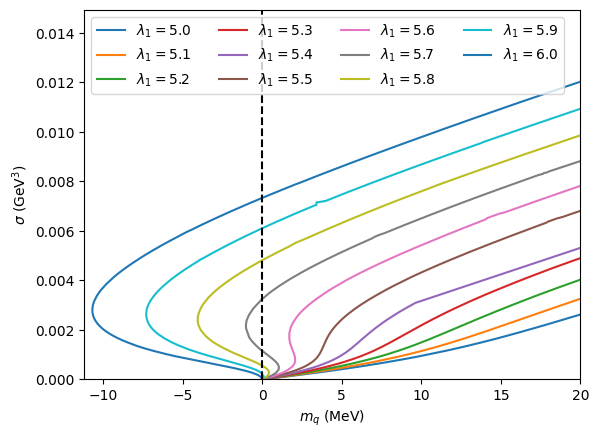

In [9]:
#plot all the sigma_improved vs mq_improved curves on the same plot, with different colors for each value of lambda1
for i in range(len(lambda1_array)):
    # plt.plot(mq_improved_list[i],sigma_improved_list[i]/1e9,label=r'$\lambda_1=$'+str(lambda1_array[i]))
    rounded_lambda1 = round(lambda1_array[i], 1)
    plt.plot(mq_improved_list[i], sigma_improved_list[i]/1e9, label=r'$\lambda_1=$' + str(rounded_lambda1))

plt.xlim([min(mq_improved)-.5,20])
#put a vertical gridline at mq=0
plt.axvline(x=0,linestyle='dashed',color='black')
# plt.xlim(0,20)
#make the ylimits from 0 to the value of sigma improved at approximately mq=20 (there may not be a value of sigma_improved at exactly mq=20)
plt.ylim([0,sigma_improved[np.where(mq_improved>20)[0][0]]/1e9])
# make the legend horizontal
plt.legend(ncol=4)
plt.xlabel(r'$m_q$ (MeV)')
plt.ylabel(r'$\sigma$ (GeV$^3$)')
#export the figure as eps and png files
# plt.savefig('sigma_vs_mq_T0_3flavor.eps',bbox_inches='tight')
# plt.savefig('sigma_vs_mq_T0_3flavor.png',bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


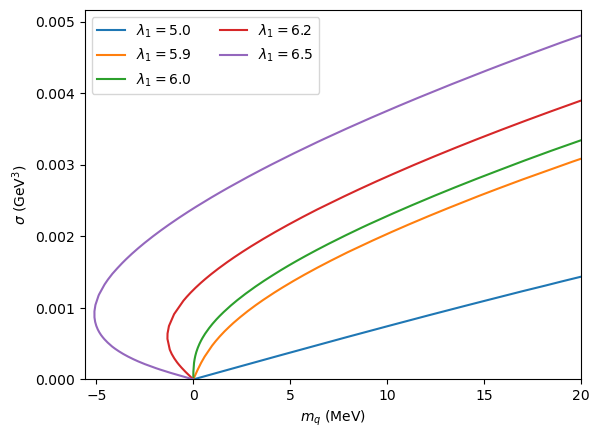

In [ ]:
# repeat the same plot, with only the following lambda1 values: 5.3, 5.5, 5.6, 5.7, 5.8, 6.0
#plot all the sigma_improved vs mq_improved curves on the same plot, with different colors for each value of lambda1
for i in range(len(lambda1_array)):
    if i in [0,9,10,12,15]:
        # plt.plot(mq_improved_list[i],sigma_improved_list[i]/1e9,label=r'$\lambda_1=$'+str(lambda1_array[i]))
        rounded_lambda1 = round(lambda1_array[i], 1)
        plt.plot(mq_improved_list[i], sigma_improved_list[i]/1e9, label=r'$\lambda_1=$' + str(rounded_lambda1))
plt.xlim([min(mq_improved)-.5,20])
#make the ylimits from 0 to the value of sigma improved at approximately mq=20 (there may not be a value of sigma_improved at exactly mq=20)
plt.ylim([0,sigma_improved[np.where(mq_improved>20)[0][0]]/1e9])
# make the legend horizontal
plt.legend(ncol=2)
plt.xlabel(r'$m_q$ (MeV)')
plt.ylabel(r'$\sigma$ (GeV$^3$)')
#export the figure as eps and png files
# plt.savefig('sigma_vs_mq_T0_2flavor_subset.eps',bbox_inches='tight')
# plt.savefig('sigma_vs_mq_T0_2flavor_subset.png',bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd
# create a pandas dataframe with columns lambda1, mq_improved, sigma_improved
# the length of mq_improved and sigma_improved are different for each value of lambda1, so I can't create a numpy array
# instead, I will create a list of lists
data=[]
for i in range(len(lambda1_array)):
    data.append([lambda1_array[i],mq_improved_list[i],sigma_improved_list[i]])
# create a pandas dataframe from the list of lists
df=pd.DataFrame(data,columns=['lambda1','mq_improved','sigma_improved'])
#pickle the dataframe
df.to_pickle('sigma_vs_mq_T0_3flavor.pkl')
#export the dataframe as a csv file
df.to_csv('sigma_vs_mq_T0_3flavor.csv')